# UW Dining Spending Analysis

This notebook explores my UW dining card transactions from **July-August 2025**
This dataset contains:
- Date & Time of Transaction
- Charge amount
- Balance after purchase
- Location of purchase

### Goals
- Understand how much I spend daily and weekly
- See which locations I spend most of my money at
- Find patterns (weekdays vs weekends)
- Estimate how long my balance will last at my current spending rate


In [56]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
# load the dataset
df = pd.read_csv('uw_dining_data.csv')
df.head()

,Date,Time,Charge,Balance,Location
0,2025-JUL-07,12:21 PM,12.00,1164.60,Local Point
1,2025-JUL-07,03:26 PM,7.45,1157.15,Starbucks LS - Suzzallo
2,2025-JUL-07,06:40 PM,15.00,1142.15,Local Point
3,2025-JUL-08,10:39 AM,14.35,1127.80,Starbucks LS - Suzzallo
4,2025-JUL-08,05:35 PM,15.00,1112.80,Local Point


In [58]:
# clean data
# convert 'Date' and 'Time' to datetime
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# convert to numeric
df['Charge'] = df['Charge'].astype(float)
df['Balance'] = df['Balance'].astype(float)

# sort by DateTime
df = df.sort_values(by='DateTime')

# drop the date and time
df = df.drop(columns=['Date', 'Time'])

df.head()

C:\Users\user\AppData\Local\Temp\ipykernel_10416\3054409890.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])


,Charge,Balance,Location,DateTime
0,12.00,1164.60,Local Point,2025-07-07 12:21:00
1,7.45,1157.15,Starbucks LS - Suzzallo,2025-07-07 15:26:00
2,15.00,1142.15,Local Point,2025-07-07 18:40:00
3,14.35,1127.80,Starbucks LS - Suzzallo,2025-07-08 10:39:00
4,15.00,1112.80,Local Point,2025-07-08 17:35:00


## Summary Statistics

In [59]:
# number of transactions
print(f"Total number of transactions: {len(df)}")

# Date range
print(f"Date range: {df['DateTime'].min().date()} to {df['DateTime'].max().date()}")

# total spending
print(f"Total spending: ${df['Charge'].sum().round(2)}")

# average spending per transaction
print(f"Average spending per transaction: ${df['Charge'].mean().round(2)}")

# maximum single transaction
print(f"Maximum single transaction: ${df['Charge'].max().round(2)}")

# minimum single transaction
print(f"Minimum single transaction: ${df['Charge'].min().round(2)}")

Total number of transactions: 56
Date range: 2025-07-07 to 2025-08-07
Total spending: $767.09
Average spending per transaction: $13.7
Maximum single transaction: $21.67
Minimum single transaction: $6.9


In [60]:
# Group by date
daily = df.groupby(df['DateTime'].dt.date)['Charge'].sum()

print("Average daily spending: $", daily.mean().round(2))
print("Max daily spending: $", daily.max())
print("Min daily spending: $", daily.min())

Average daily spending: $ 33.35
Max daily spending: $ 63.82
Min daily spending: $ 12.0


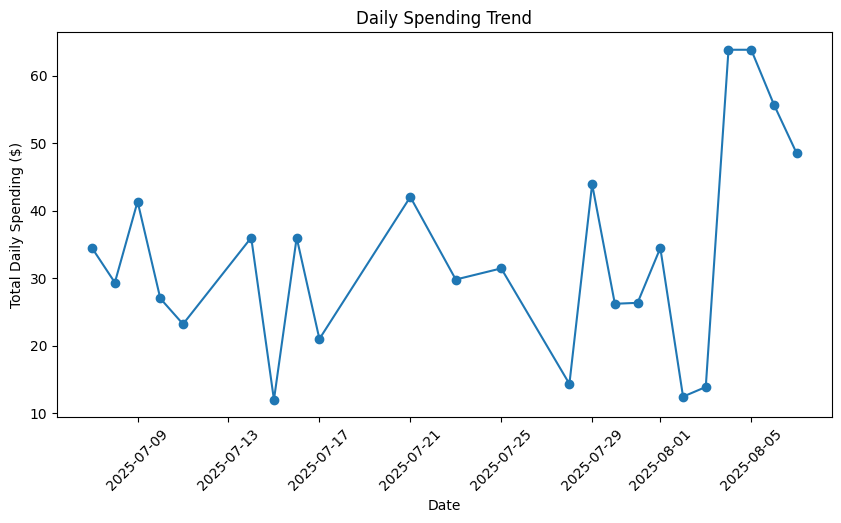

In [61]:
# Visualize daily spending trend
plt.figure(figsize=(10, 5))
daily.plot(kind='line',marker='o')

plt.title('Daily Spending Trend')
plt.xlabel('Date')
plt.ylabel('Total Daily Spending ($)')

plt.xticks(rotation=45)
plt.show()

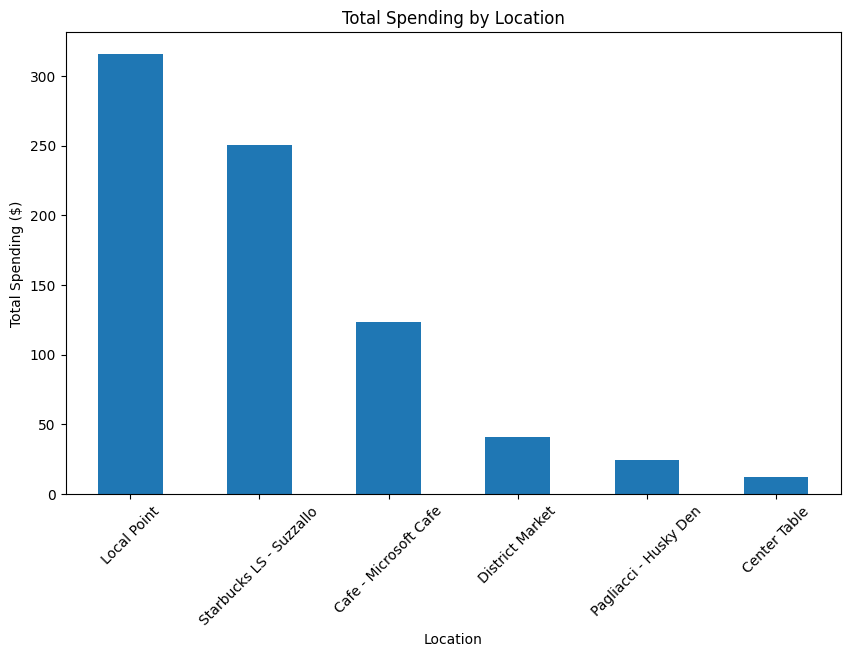

In [62]:
# visualize spending by location
location_totals = df.groupby('Location')['Charge'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
location_totals.plot(kind='bar')

plt.title('Total Spending by Location')
plt.xlabel('Location')
plt.ylabel('Total Spending ($)')
plt.xticks(rotation=45)
plt.show()

In [63]:
# get last balance of each day
daily_balance = df.groupby(df['DateTime'].dt.date)['Balance'].last()
daily_balance.head()

DateTime
2025-07-07    1142.15
2025-07-08    1112.80
2025-07-09    1071.45
2025-07-10    1044.45
2025-07-11    1021.25
Name: Balance, dtype: float64

In [64]:
# prepare data for regression
import numpy as np
from sklearn.linear_model import LinearRegression

# day numbers (0, 1, 2, ...)
X = np.arange(len(daily_balance)).reshape(-1, 1)

# Balances
y = daily_balance.values

In [65]:
from sklearn.model_selection import train_test_split

# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# shuffle=False preserves the time order for time series

In [66]:
# fit a regression model
model = LinearRegression()
model.fit(X_train, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [67]:
# predict on test set
y_pred = model.predict(X_test)

In [68]:
# evaluate with mse and r2
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", round(mse, 2))
print("R² score:", round(r2, 2))


Mean Squared Error: 3210.18
R² score: 0.53


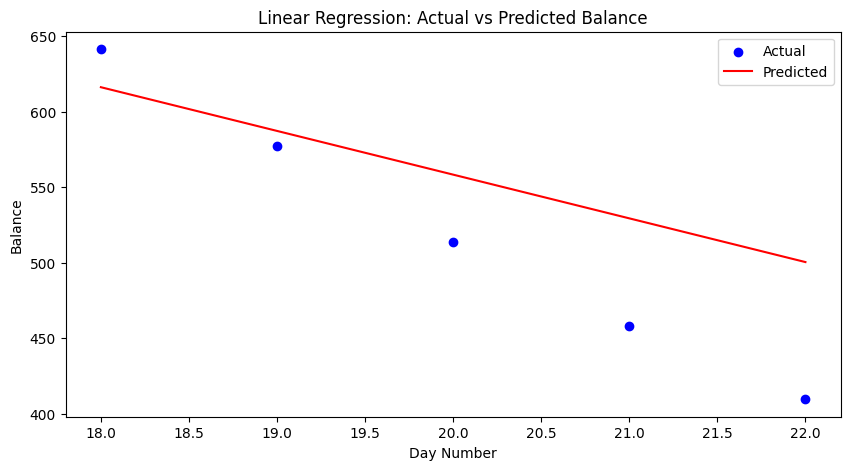

In [69]:
# plot results
plt.figure(figsize=(10,5))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.plot(X_test, y_pred, color='red', label='Predicted')
plt.xlabel("Day Number")
plt.ylabel("Balance")
plt.title("Linear Regression: Actual vs Predicted Balance")
plt.legend()
plt.show()


In [70]:
slope = model.coef_[0]
print("Average daily decrease in balance: $", round(-slope, 2))


Average daily decrease in balance: $ 28.96


In [71]:
# Last day number in your dataset
last_day = X[-1][0]

# Predict for next 30 days
future_days = np.arange(last_day + 1, last_day + 31).reshape(-1, 1)

future_balance = model.predict(future_days)

# Find first day where predicted balance <= 0
zero_day_index = np.argmax(future_balance <= 0)
if zero_day_index > 0:
    predicted_zero_day = future_days[zero_day_index][0]
    print("Predicted day when balance hits zero (relative to day 0):", predicted_zero_day)
else:
    print("Balance does not hit zero in the next 30 days based on model.")

Predicted day when balance hits zero (relative to day 0): 40


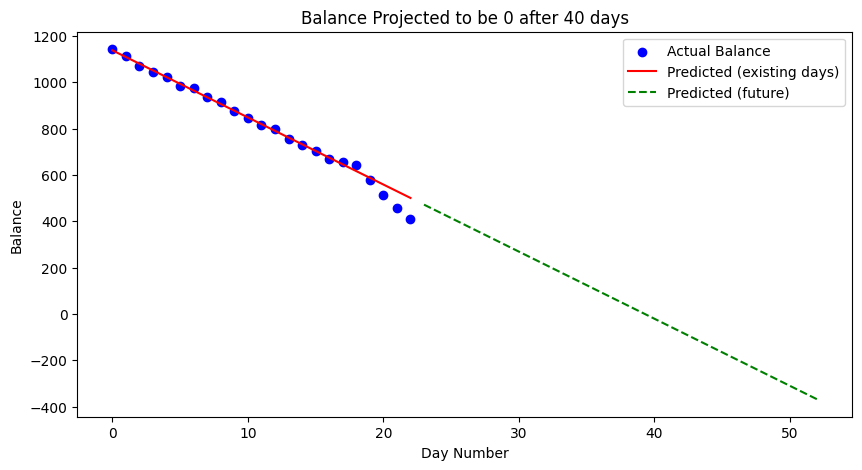

In [ ]:
plt.figure(figsize=(10,5))
# Actual balances
plt.scatter(X, y, color='blue', label='Actual Balance')
# Model predictions for existing data
plt.plot(X, model.predict(X), color='red', label='Predicted (existing days)')
# Predictions for future days
plt.plot(future_days, future_balance, color='green', linestyle='--', label='Predicted (future)')

plt.xlabel("Day Number")
plt.ylabel("Balance")
plt.title("Balance Projected to be 0 after 40 days")
plt.legend()
plt.show()

## Insights from Dining Analysis

- Average daily spending: $ 33.35 
- Location where I spend the most: Local Point  
- Balance is steadily decreasing, roughly $28.96 per day  
- Linear regression predicts the balance will reach $0 around Day 40
